In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import os
import pickle
import time
import seaborn as sns
from shapely.geometry import LineString, Point

In [14]:
# load road network from a binary pickle file 
fname = 'Columbia_simplified_graph.pkl'
rf = open(fname,"rb")
G = pickle.load(rf)
rf.close()

# Change edge key to 1 (This simplified graph does not have multiple edges)
nonZero_keys = []
for edge in G.edges(keys=True, data=True):
    u,v,k,d = edge
    if k != 0:
        nonZero_keys.append(edge)
for u,v,k,d in nonZero_keys:
    G.add_edge(u, v, key=0, **d)
    G.remove_edge(u, v, key=k)

# Refine edge type
etype_val = {'motorway':0, 'motorway_link':1, 'primary':2, 'primary_link':3,
               'secondary':4, 'secondary_link':5, 'tertiary':6, 'tertiary_link':7,
               'residential':8, 'unclassified':9, 'trunk':10}

for edge in G.edges:
    edge_type = G.edges[edge]['highway']
    
    # Set the most slow edge type for consolidated edges
    if type(edge_type) == list:
        edge_type = sorted(edge_type, reverse=True, key = lambda d: etype_val[d])
        edge_type = edge_type[0]
        G.edges[edge]['highway'] = edge_type

# Set default speed of vehicles on each type of road
hwy_speeds = {'motorway': 110,
            'motorway_link': 60,
            'primary': 60,
            'primary_link': 60,
            'secondary': 50,
            'secondary_link': 50,
            'tertiary': 40,
            'tertiary_link': 40,
            'residential': 40,
            'unclassified': 40}

# Plug in to the graph. 'speed_kph' attribute is added to each edge and set to the default speed.
G = ox.add_edge_speeds(G, hwy_speeds)

# Add 'travel_time' property to each node, which is 'length' divided by 'speed_kph'
G = ox.add_edge_travel_times(G)

# Add signal light delay on the travel_time attributes
for edge in G.edges:
    edge_type = G.edges[edge]['highway']
    edge_len = G.edges[edge]['length']
    signal_delay = 0

    if edge_type == 'primary':
        signal_delay = 10

    elif edge_type == 'secondary':
        signal_delay = 10

    elif edge_type == 'tertiary':
        signal_delay = 6

    elif edge_type == 'residential':
        signal_delay = 4
            
    G.edges[edge]['travel_time'] += signal_delay

travel_time = nx.get_edge_attributes(G, 'travel_time')
nx.set_edge_attributes(G, travel_time,'total_delay') # initialize 'total_delay' attributes
nx.set_edge_attributes(G, travel_time,'expected_delay') # initialize 'expected_delay' attributes

Number of edges:  15275
residential       9637
tertiary          1595
secondary         1578
primary           1226
unclassified       444
motorway_link      361
motorway           162
trunk               99
primary_link        58
secondary_link      47
tertiary_link       42
trunk_link          26
Name: highway, dtype: int64


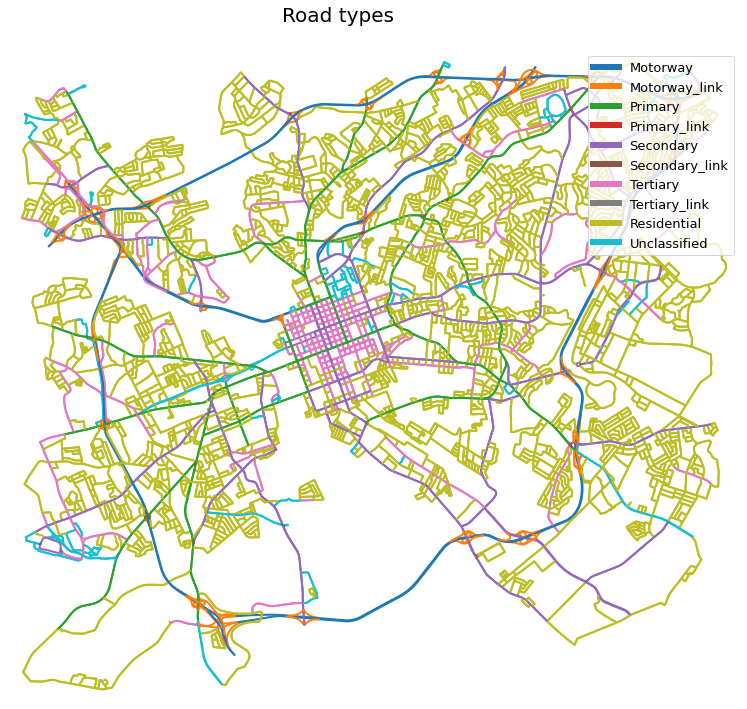

In [9]:
# Plot edge types on the map
edge_type_dic = {}
for (u,v,k) in G.edges:
    if G.edges[u,v,k]['highway'] == 'motorway':
        edge_type_dic[(u,v,k)] = 0
    elif G.edges[u,v,k]['highway'] == 'motorway_link':
        edge_type_dic[(u,v,k)] = 1
    elif G.edges[u,v,k]['highway'] == 'primary':
        edge_type_dic[(u,v,k)] = 2
    elif G.edges[u,v,k]['highway'] == 'primary_link':
        edge_type_dic[(u,v,k)] = 3
    elif G.edges[u,v,k]['highway'] == 'secondary':
        edge_type_dic[(u,v,k)] = 4
    elif G.edges[u,v,k]['highway'] == 'secondary_link':
        edge_type_dic[(u,v,k)] = 5
    elif G.edges[u,v,k]['highway'] == 'tertiary':
        edge_type_dic[(u,v,k)] = 6
    elif G.edges[u,v,k]['highway'] == 'tertiary_link':
        edge_type_dic[(u,v,k)] = 7
    elif G.edges[u,v,k]['highway'] == 'residential':
        edge_type_dic[(u,v,k)] = 8
    else:  # unclassified
        edge_type_dic[(u,v,k)] = 9
        
        
# Add edge type as a numerical value to edge attribute
nx.set_edge_attributes(G, edge_type_dic, "edge_type")

# Plot a map that represents the type of each edge
ec = ox.plot.get_edge_colors_by_attr(G, "edge_type", cmap='tab10', num_bins=10, start=0, stop=1, na_color='none')
edge_type_fig, edge_type_ax = ox.plot_graph(G, figsize=(40, 12), node_color='white', node_size=0,
                                          edge_linewidth=2, edge_color=ec, show=False, close=False, bgcolor='w')

edge_type_fig.suptitle(t='Road types', y=0.93, size=20)
   
# Add legend
cmap = plt.cm.get_cmap('tab10')

line_motor, = plt.plot([0, 0, 0], label='Motorway', c=cmap(0), linewidth = 6)
line_motor_link, = plt.plot([0, 0, 0], label='Motorway_link', c=cmap(1), linewidth = 6)
line_primary, = plt.plot([0, 0, 0], label='Primary', c=cmap(2), linewidth = 6)
line_primary_link, = plt.plot([0, 0, 0], label='Primary_link', c=cmap(3), linewidth = 6)
line_secondary, = plt.plot([0, 0, 0], label='Secondary', c=cmap(4), linewidth = 6)
line_secondary_link, = plt.plot([0, 0, 0], label='Secondary_link', c=cmap(5), linewidth = 6)
line_tertiary, = plt.plot([0, 0, 0], label='Tertiary', c=cmap(6), linewidth = 6)
line_tertiary_link, = plt.plot([0, 0, 0], label='Tertiary_link', c=cmap(7), linewidth = 6)
line_res, = plt.plot([0, 0, 0], label='Residential', c=cmap(8), linewidth = 6)
line_unclass, = plt.plot([0, 0, 0], label='Unclassified', c=cmap(9), linewidth = 6)


plt.legend([line_motor, line_motor_link,
            line_primary, line_primary_link,
            line_secondary, line_secondary_link,
            line_tertiary, line_tertiary_link,
            line_res, line_unclass],
           ['Motorway', 'Motorway_link',
            'Primary', 'Primary_link',
            'Secondary', 'Secondary_link',
            'Tertiary', 'Tertiary_link',
            'Residential', 'Unclassified'], prop={'size': 13})

print("Number of edges: ", G.number_of_edges())
print(ox.graph_to_gdfs(G, nodes=False)['highway'].value_counts())
plt.show()
plt.close('all')

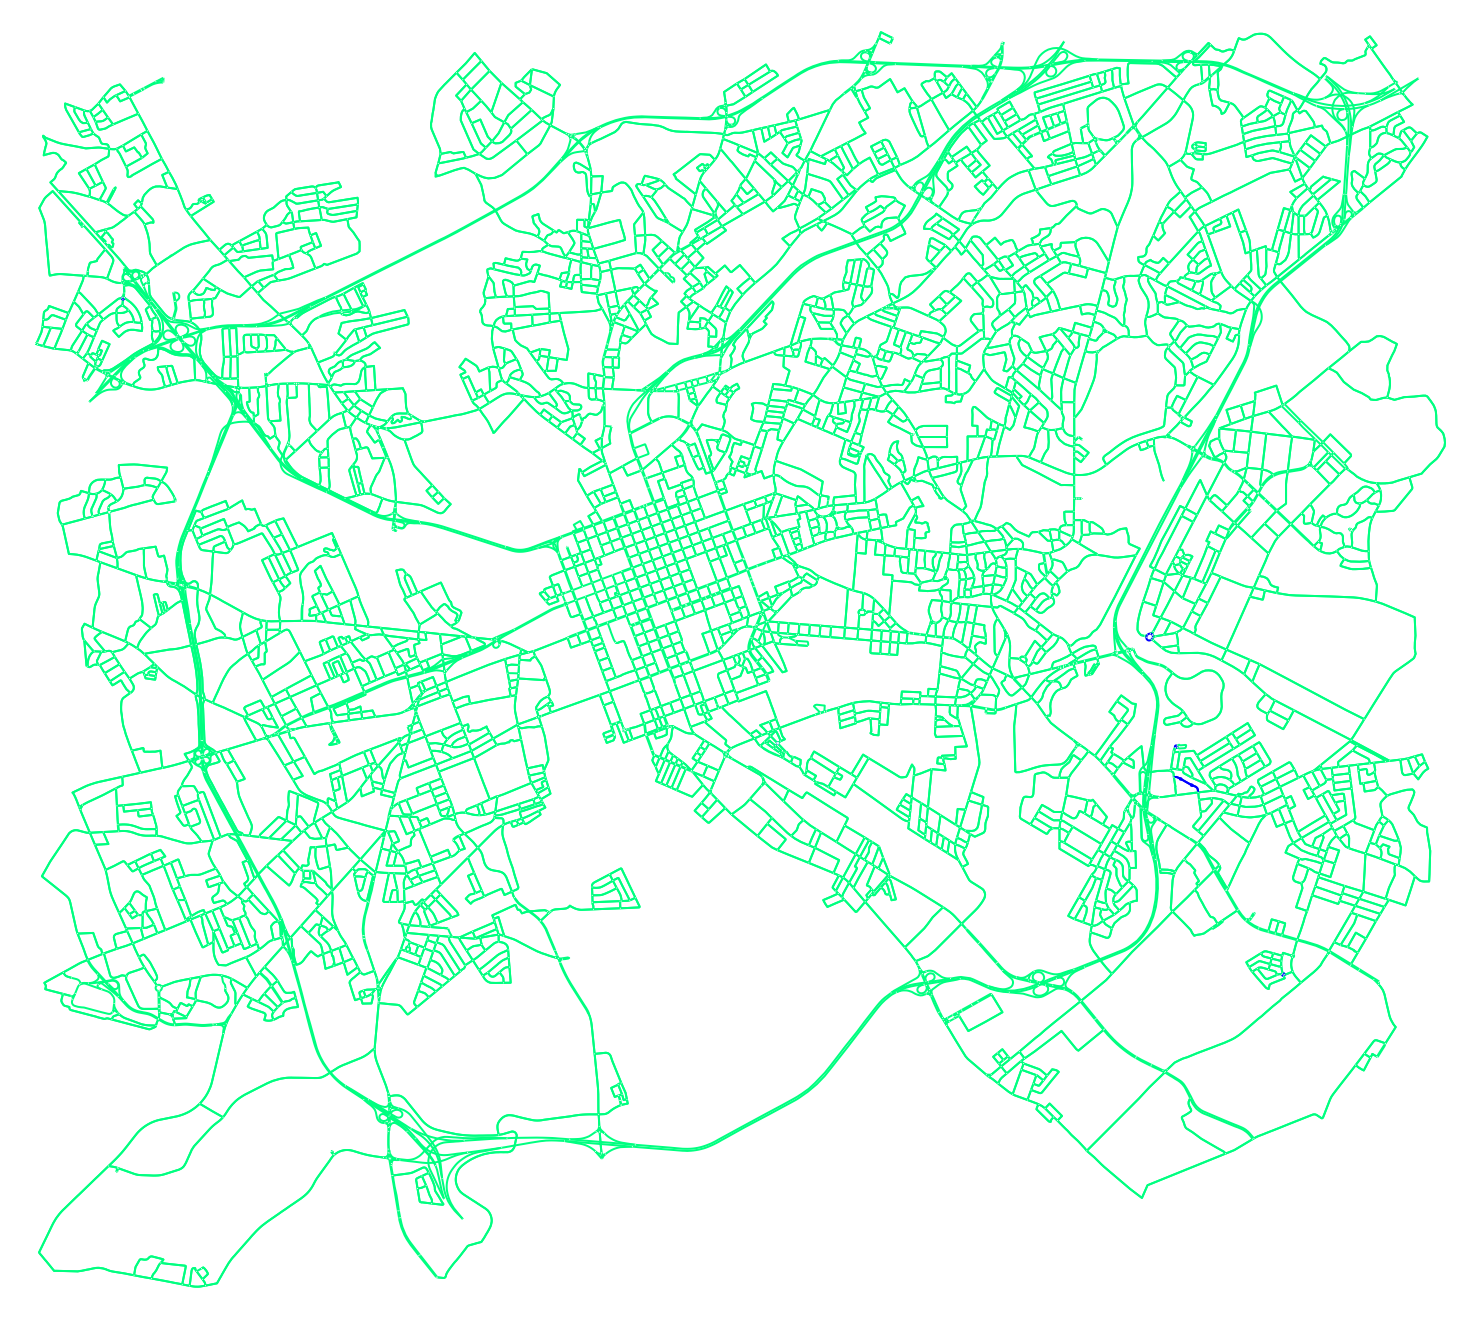

'\nx = np.arange( 3 )\nfor i in x:\n    plt.plot( i*x, x, label=\'label\'+str(i), lw=5 )\n# Add a legend \n# (with a negative gap between line and text, and set "handle" (line) length to 0)\nlegend = plt.legend(handletextpad=0, handlelength=0, prop={\'size\': 30})\n'

In [10]:
nx.set_edge_attributes(G, 0, 'ra')
for u,v,k,d in G.edges(data=True, keys=True):
    if 'junction' in d:
        if d['junction'] == 'roundabout':
            d['ra'] = 1
        
ec = ox.plot.get_edge_colors_by_attr(G, 'ra', cmap='winter_r', start=0, stop=1, na_color='none')

# Plot a map
fig, ax = ox.plot_graph(G, figsize=(40, 24), node_color='white',
                        node_size=1, edge_linewidth=2,edge_color=ec, show=False, close=False, bgcolor='w')

plt.show()
plt.close('all')
"""
x = np.arange( 3 )
for i in x:
    plt.plot( i*x, x, label='label'+str(i), lw=5 )
# Add a legend 
# (with a negative gap between line and text, and set "handle" (line) length to 0)
legend = plt.legend(handletextpad=0, handlelength=0, prop={'size': 30})
"""

Minimum travel time of an edge: 0.2 second


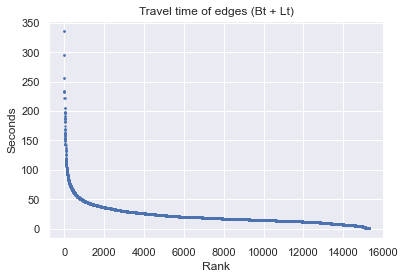

In [11]:
sns.set()

sorted_tt = sorted(travel_time.values(), reverse=True)
print('Minimum travel time of an edge:', min(sorted_tt), 'second')
plt.scatter(range(0, len(sorted_tt)), sorted_tt, s=2)

plt.title('Travel time of edges (Bt + Lt)')
plt.xlabel('Rank')
plt.ylabel('Seconds')

plt.show()
plt.close('all')

((114084664, 113962367, 0), 0.07499556986990263)


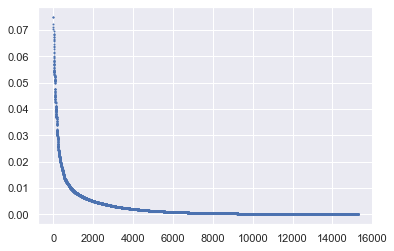

((113952363, 405138198, 0), 0.07481861656878061)


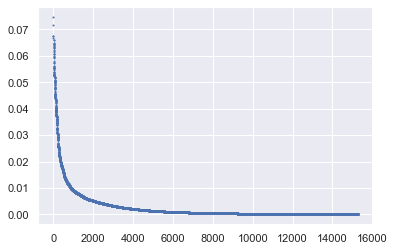

((113393750, 113412333, 0), 0.07991326058291691)


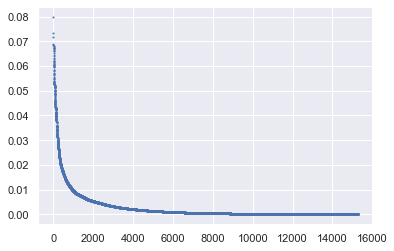

((114092691, 114049391, 0), 0.10263065312365707)


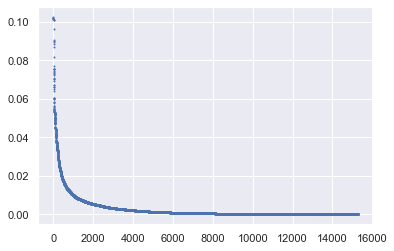

((2533952894, 1883124187, 0), 0.10664829522951232)


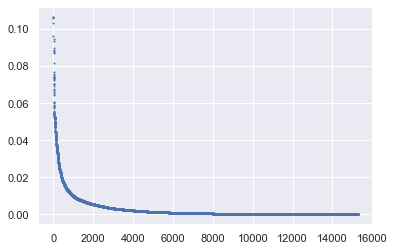

In [12]:
top5_bc = []

for _ in range(0,5):
    # Get betweenness centrality of each edge
    G2 = nx.DiGraph(G)
    bet_cent=nx.edge_betweenness_centrality(G2, weight='travel_time')

    # Add betweenness centrality to edge attribute
    formatted_bet_cent = {}
    for (u, v), value in bet_cent.items():
        keys = list(G.get_edge_data(u,v).keys())
        if len(keys) != 1: raise ValueError('Simplified graph has multi-edge')
        key = keys[0]
        formatted_bet_cent[(u, v, key)] = value

    #nx.set_edge_attributes(G1, 0, "betweenness_centrality")
    nx.set_edge_attributes(G, formatted_bet_cent, "betweenness_centrality")
    bc = nx.get_edge_attributes(G, 'betweenness_centrality')
    
    highest_bc = sorted(bc.items(), reverse=True, key= lambda d: d[1])[0]
    bc_vals = sorted(bc.values(), reverse=True)
    print(highest_bc)

    target_edge = highest_bc[0]
    top5_bc.append(target_edge)

    plt.scatter(range(0,len(bc_vals)), bc_vals, s=1)
    plt.show()
    
    G.edges[target_edge]['travel_time'] = 999999999999999 

Top-5 bet. cent. edges:
No. 1 : (114084664, 113962367, 0)
No. 2 : (113952363, 405138198, 0)
No. 3 : (113393750, 113412333, 0)
No. 4 : (114092691, 114049391, 0)
No. 5 : (2533952894, 1883124187, 0)


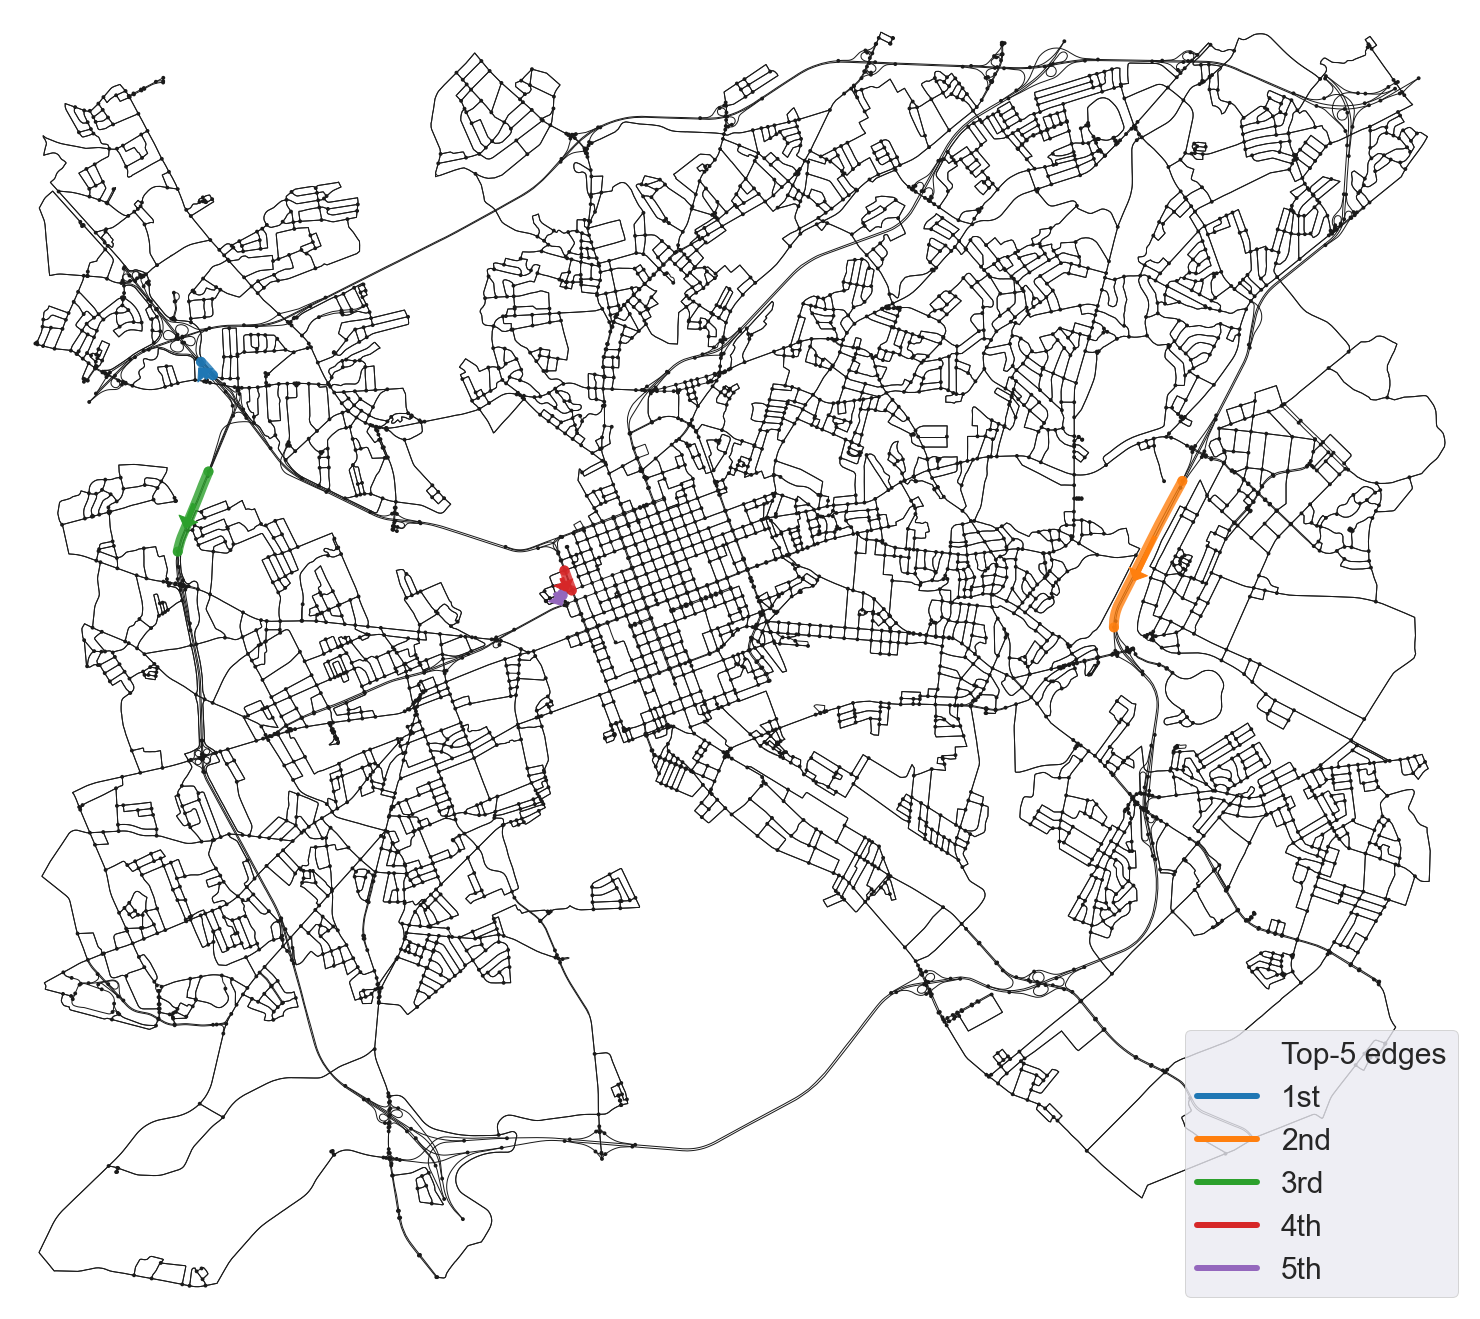

In [13]:
routes = []
for u,v,k in top5_bc:
    rt = [u,v]
    routes.append(rt)

print('Top-5 bet. cent. edges:')
for i, edge in enumerate(top5_bc):
    print('No.',i+1,':' , edge)
    
default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = ox.plot.plot_graph_routes(G, routes, figsize=(40,24), route_colors=default_colors[:5], 
                                    edge_color='k', node_color='k', bgcolor='w',
                                    route_linewidths=10, show=False, close=False, route_alpha=0.8)

for i, e in enumerate(routes):
    start_node = e[0]
    end_node = e[1]
    start_coord = (G.nodes[start_node]['x'] - 0.0006, G.nodes[start_node]['y'] - 0.0006)
    end_coord =  (G.nodes[end_node]['x'] - 0.0006, G.nodes[end_node]['y'] - 0.0006)

    # Annotate node ID if needed
    #atk_ax.annotate(start_node, xy=start_coord, color='white', weight='bold')
    #atk_ax.annotate(end_node, xy=end_coord, color='blue', weight='bold')

    middle_coord = (start_coord[0] + 0.5*(end_coord[0] - start_coord[0]), 
                    start_coord[1] + 0.5*(end_coord[1] - start_coord[1]))

    arrow_len = 0.001

    x_s = start_coord[0]
    y_s = start_coord[1]
    x_e = end_coord[0]
    y_e = end_coord[1]
    x_m = middle_coord[0]
    y_m = middle_coord[1]

    x_diff = x_s - x_m
    y_diff = y_s - y_m
    grad = y_diff / x_diff

    x_sign = x_diff / abs(x_diff)
    y_sign = y_diff / abs(y_diff)

    arrow_start_coord = (middle_coord[0] + 0.3*(start_coord[0] - middle_coord[0]), middle_coord[1] + 0.3*(start_coord[1] - middle_coord[1]))
    arrow_end_coord = (middle_coord[0] + 0.3*(end_coord[0] - middle_coord[0]), middle_coord[1] + 0.3*(end_coord[1] - middle_coord[1]))    
    dist = (((arrow_start_coord[0]-arrow_end_coord[0])**2 + (arrow_start_coord[1] - arrow_end_coord[1])**2)**0.5)

    if dist < 0.003:
            x_mov = x_sign*((arrow_len**2 / (1 + grad**2))**0.5)
            y_mov = y_sign*((arrow_len**2 - x_mov**2) ** 0.5)
            arrow_start_coord = (middle_coord[0] + x_mov, middle_coord[1] + y_mov)
            arrow_end_coord = (middle_coord[0] - x_mov, middle_coord[1] - y_mov)

    ax.annotate('', xy= arrow_end_coord, color='blue', weight='bold', 
                xytext= arrow_start_coord, textcoords='data', 
                arrowprops=dict(color=default_colors[i], headwidth=20, headlength=10, lw=1))

# Add legend
line_label, = plt.plot([0, 0, 0], label='1st', c='none', linewidth = 0)
line_1st, = plt.plot([0, 0, 0], label='1st', c=default_colors[0], linewidth = 6)
line_2nd, = plt.plot([0, 0, 0], label='2nd', c=default_colors[1], linewidth = 6)
line_3rd, = plt.plot([0, 0, 0], label='3rd', c=default_colors[2], linewidth = 6)
line_4th, = plt.plot([0, 0, 0], label='4th', c=default_colors[3], linewidth = 6)
line_5th, = plt.plot([0, 0, 0], label='5th', c=default_colors[4], linewidth = 6)


plt.legend([line_label, line_1st, line_2nd, line_3rd, line_4th, line_5th], 
           ['Top-5 edges', '1st', '2nd', '3rd', '4th', '5th'], prop={'size': 30})

plt.show()
plt.close('all')

In [15]:
## Compute betweenness centrality weighted by 'length' and 'aggr_node_num'              
def accumulate_sigma(G, path, bc_dic, multiple, weight='travel_time'):    
    for u, v in zip(path[:-1], path[1:]):
        all_edges_btwn_nodes = list(G.get_edge_data(u,v).items())
        edge_dat_sorted_by_length = sorted(all_edges_btwn_nodes, reverse=False, key= lambda d: d[1][weight])
        shortest_edge_key = edge_dat_sorted_by_length[0][0]
        shortest_edge = (u, v, shortest_edge_key)

        bc_dic[shortest_edge] += multiple
        
def estimated_betweenness_centrality(G, weight='travel_time', normalize='True'):
    
    # original node number
    n = 11113
    print('Original graph has', n, 'nodes')
    
    total_start_time = time.time()
    
    betweenness_centrality = dict.fromkeys(G.edges, 0)    

    first_iteration = True
    # path[source][target]=[list of nodes in path]
    for src, path_dic in nx.shortest_path(G, weight = weight).items():
        start_time = time.time()
        aggr_on_src = G.nodes[src]['aggr_node_num']
        
        for dst in path_dic:
            if src != dst:
                aggr_on_dst = G.nodes[dst]['aggr_node_num']
                multiple = aggr_on_src * aggr_on_dst
                path = path_dic[dst]
                accumulate_sigma(G, path, betweenness_centrality, multiple, weight=weight)
                
        end_time = time.time()
        if first_iteration:
            elapsed_time = end_time - start_time
            print('Estimated time to finish:', elapsed_time * (n-1))
            first_iteration = False
    
    if normalize:
        for edge in betweenness_centrality:
            denominator = n * (n-1)
            betweenness_centrality[edge] = betweenness_centrality[edge] / denominator               
            
    total_end_time = time.time()
    total_elapsed_time = total_end_time - total_start_time
    
    print('Elapsed time for the computation: ', total_elapsed_time)
    
    return betweenness_centrality

Original graph has 11113 nodes
Estimated time to finish: 3364.8374519348145
Elapsed time for the computation:  1774.3605046272278
((114084664, 113962367, 0), 0.08608266275835753)


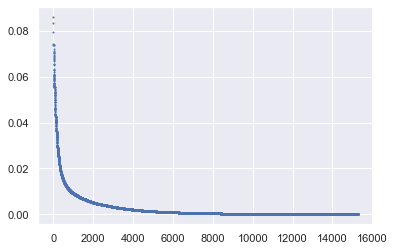

Original graph has 11113 nodes
Estimated time to finish: 2933.858745574951
Elapsed time for the computation:  1803.184505701065
((113393750, 113412333, 0), 0.07386509205566053)


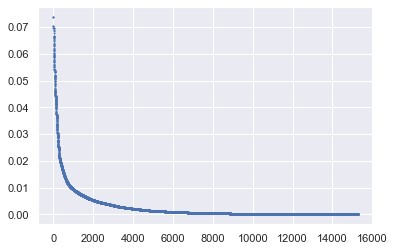

Original graph has 11113 nodes
Estimated time to finish: 3889.9010066986084
Elapsed time for the computation:  1809.1094765663147
((114092691, 114049391, 0), 0.0934081064111736)


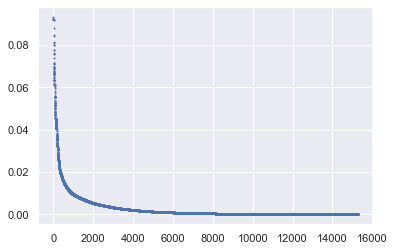

Original graph has 11113 nodes
Estimated time to finish: 2909.0797748565674
Elapsed time for the computation:  1852.0115180015564
((2533952894, 1883124187, 0), 0.09714758866398866)


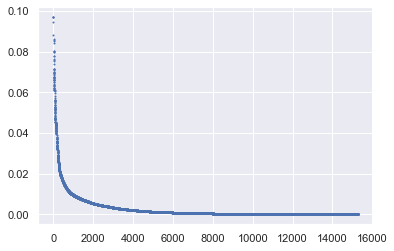

Original graph has 11113 nodes
Estimated time to finish: 3407.962875366211
Elapsed time for the computation:  1886.1984145641327
((114049392, 2925183409, 0), 0.09486046644867122)


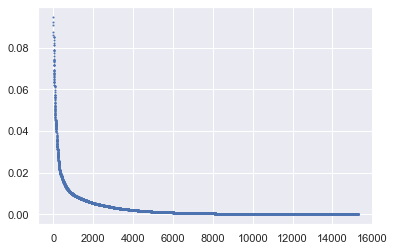

In [16]:
top5_bc = []

for _ in range(0,5):
    # Get betweenness centrality of each edge
    bc = estimated_betweenness_centrality(G, weight='travel_time', normalize='True')
    
    highest_bc = sorted(bc.items(), reverse=True, key= lambda d: d[1])[0]
    bc_vals = sorted(bc.values(), reverse=True)
    print(highest_bc)

    target_edge = highest_bc[0]
    top5_bc.append(target_edge)

    plt.scatter(range(0,len(bc_vals)), bc_vals, s=1)
    plt.show()
    
    G.edges[target_edge]['travel_time'] = 999999999999999 

Top-5 bet. cent. edges:
No. 1 : (114084664, 113962367, 0)
No. 2 : (113393750, 113412333, 0)
No. 3 : (114092691, 114049391, 0)
No. 4 : (2533952894, 1883124187, 0)
No. 5 : (114049392, 2925183409, 0)


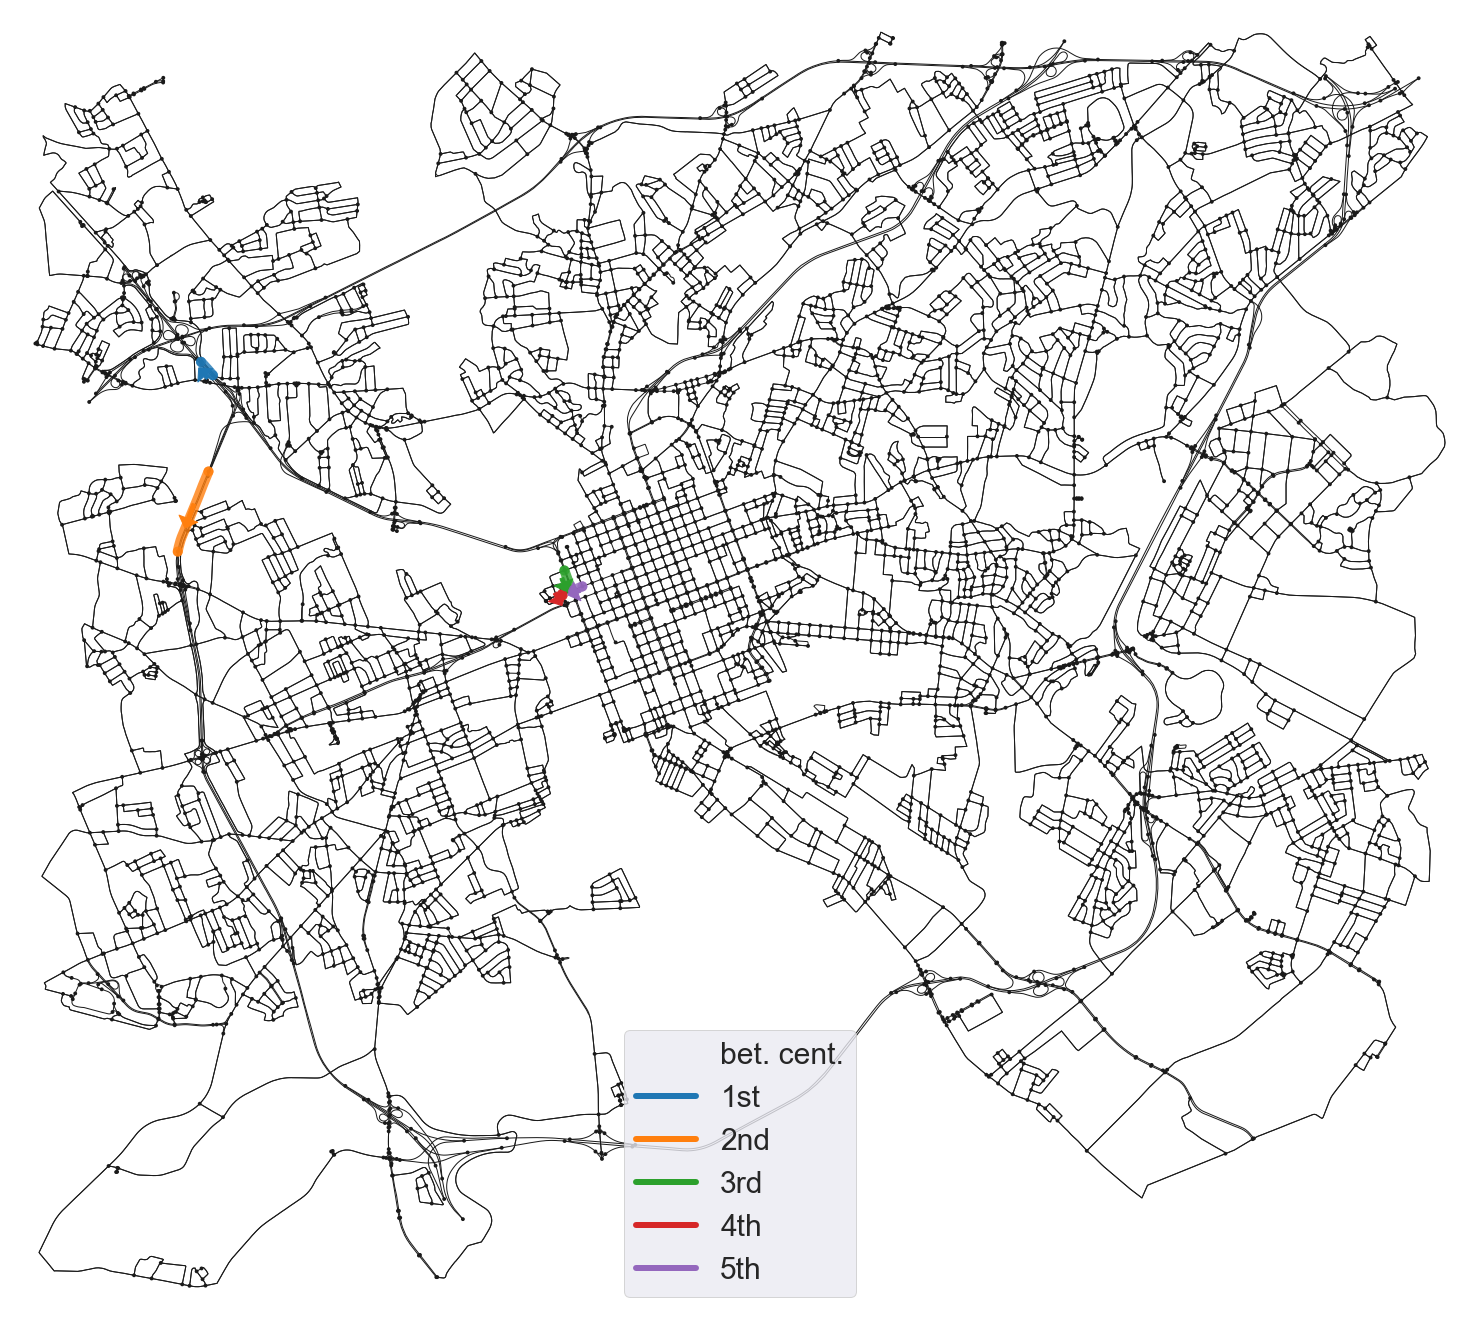

In [17]:
routes = []
for u,v,k in top5_bc:
    rt = [u,v]
    routes.append(rt)

print('Top-5 bet. cent. edges:')
for i, edge in enumerate(top5_bc):
    print('No.',i+1,':' , edge)
    
default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = ox.plot.plot_graph_routes(G, routes, figsize=(40,24), route_colors=default_colors[:5], 
                                    edge_color='k', node_color='k', bgcolor='w',
                                    route_linewidths=10, show=False, close=False, route_alpha=0.8)

for i, e in enumerate(routes):
    start_node = e[0]
    end_node = e[1]
    start_coord = (G.nodes[start_node]['x'] - 0.0006, G.nodes[start_node]['y'] - 0.0006)
    end_coord =  (G.nodes[end_node]['x'] - 0.0006, G.nodes[end_node]['y'] - 0.0006)

    # Annotate node ID if needed
    #atk_ax.annotate(start_node, xy=start_coord, color='white', weight='bold')
    #atk_ax.annotate(end_node, xy=end_coord, color='blue', weight='bold')

    middle_coord = (start_coord[0] + 0.5*(end_coord[0] - start_coord[0]), 
                    start_coord[1] + 0.5*(end_coord[1] - start_coord[1]))

    arrow_len = 0.001

    x_s = start_coord[0]
    y_s = start_coord[1]
    x_e = end_coord[0]
    y_e = end_coord[1]
    x_m = middle_coord[0]
    y_m = middle_coord[1]

    x_diff = x_s - x_m
    y_diff = y_s - y_m
    grad = y_diff / x_diff

    x_sign = x_diff / abs(x_diff)
    y_sign = y_diff / abs(y_diff)

    arrow_start_coord = (middle_coord[0] + 0.3*(start_coord[0] - middle_coord[0]), middle_coord[1] + 0.3*(start_coord[1] - middle_coord[1]))
    arrow_end_coord = (middle_coord[0] + 0.3*(end_coord[0] - middle_coord[0]), middle_coord[1] + 0.3*(end_coord[1] - middle_coord[1]))    
    dist = (((arrow_start_coord[0]-arrow_end_coord[0])**2 + (arrow_start_coord[1] - arrow_end_coord[1])**2)**0.5)

    if dist < 0.003:
            x_mov = x_sign*((arrow_len**2 / (1 + grad**2))**0.5)
            y_mov = y_sign*((arrow_len**2 - x_mov**2) ** 0.5)
            arrow_start_coord = (middle_coord[0] + x_mov, middle_coord[1] + y_mov)
            arrow_end_coord = (middle_coord[0] - x_mov, middle_coord[1] - y_mov)

    ax.annotate('', xy= arrow_end_coord, color='blue', weight='bold', 
                xytext= arrow_start_coord, textcoords='data', 
                arrowprops=dict(color=default_colors[i], headwidth=20, headlength=10, lw=1))

# Add legend
line_label, = plt.plot([0, 0, 0], label='1st', c='none', linewidth = 0)
line_1st, = plt.plot([0, 0, 0], label='1st', c=default_colors[0], linewidth = 6)
line_2nd, = plt.plot([0, 0, 0], label='2nd', c=default_colors[1], linewidth = 6)
line_3rd, = plt.plot([0, 0, 0], label='3rd', c=default_colors[2], linewidth = 6)
line_4th, = plt.plot([0, 0, 0], label='4th', c=default_colors[3], linewidth = 6)
line_5th, = plt.plot([0, 0, 0], label='5th', c=default_colors[4], linewidth = 6)


plt.legend([line_label, line_1st, line_2nd, line_3rd, line_4th, line_5th], 
           ['bet. cent.', '1st', '2nd', '3rd', '4th', '5th'], prop={'size': 30})

plt.show()
plt.close('all')

In [4]:
plt.ioff()
# get a graph for a city

# Set boundaries
north, west = 34.077988, -81.134183
south, east = 33.909673, -80.908490

# load entire graph
G = ox.graph_from_bbox(north, south, east, west, network_type='drive')

# Plot a map
fig, ax = ox.plot_graph(G, figsize=(40, 24), node_color='k',
                        node_size=40, edge_linewidth=1,edge_color='k', show=False, close=False, bgcolor='w')

plt.show()
plt.close('all')

# Refine edge type
etype_val = {'motorway':0, 'motorway_link':1, 'primary':2, 'primary_link':3,
               'secondary':4, 'secondary_link':5, 'tertiary':6, 'tertiary_link':7,
               'residential':8, 'unclassified':9, 'trunk':10}

for edge in G.edges:
    edge_type = G.edges[edge]['highway']
    
    # Set the most slow edge type for consolidated edges
    if type(edge_type) == list:
        edge_type = sorted(edge_type, reverse=True, key = lambda d: etype_val[d])
        edge_type = edge_type[0]
        G.edges[edge]['highway'] = edge_type

# Set default speed of vehicles on each type of road
hwy_speeds = {'motorway': 110,
            'motorway_link': 60,
            'primary': 60,
            'primary_link': 60,
            'secondary': 50,
            'secondary_link': 50,
            'tertiary': 40,
            'tertiary_link': 40,
            'residential': 40,
            'unclassified': 40}

# Plug in to the graph. 'speed_kph' attribute is added to each edge and set to the default speed.
G = ox.add_edge_speeds(G, hwy_speeds)

# Add 'travel_time' property to each node, which is 'length' divided by 'speed_kph'
G = ox.add_edge_travel_times(G)

# Add signal light delay on the travel_time attributes
for edge in G.edges:
    edge_type = G.edges[edge]['highway']
    edge_len = G.edges[edge]['length']
    signal_delay = 0

    if edge_type == 'primary':
        signal_delay = 10

    elif edge_type == 'secondary':
        signal_delay = 10

    elif edge_type == 'tertiary':
        signal_delay = 6

    elif edge_type == 'residential':
        signal_delay = 4
            
    G.edges[edge]['travel_time'] += signal_delay

travel_time = nx.get_edge_attributes(G, 'travel_time')
nx.set_edge_attributes(G, travel_time,'total_delay') # initialize 'total_delay' attributes
nx.set_edge_attributes(G, travel_time,'expected_delay') # initialize 'expected_delay' attributes

((114084664, 113962367, 0), 0.08771429879012708)


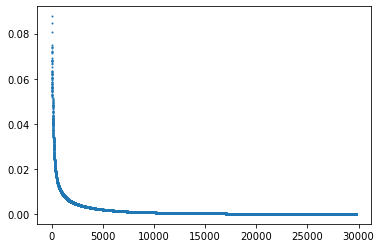

((113393750, 113412333, 0), 0.07496140213212368)


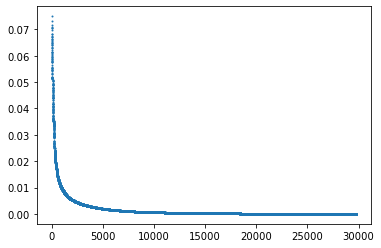

((114092691, 114049391, 0), 0.09053384418166302)


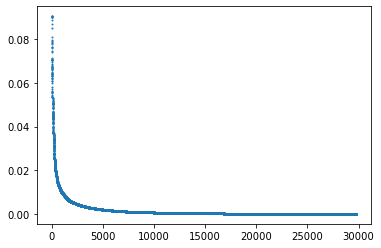

((1883124187, 657875217, 0), 0.09464665400264093)


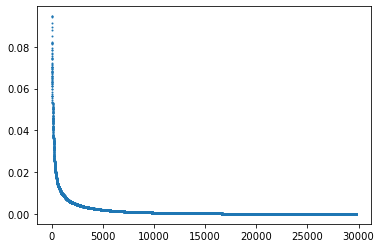

((113928685, 113928619, 0), 0.09874833103451855)


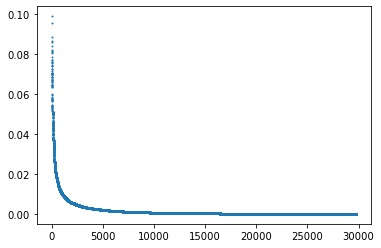

In [5]:
top5_bc = []

for _ in range(0,5):
    # Get betweenness centrality of each edge
    G2 = nx.DiGraph(G)
    bet_cent=nx.edge_betweenness_centrality(G2, weight='travel_time')

    # Add betweenness centrality to edge attribute
    formatted_bet_cent = {}
    for (u, v), value in bet_cent.items():
        formatted_bet_cent[(u, v, 0)] = value

    # Fill missing values for multi-edges
    for (u,v,k) in G.edges:    
        if not (u,v,k) in formatted_bet_cent:
            formatted_bet_cent[(u,v,k)] = formatted_bet_cent[(u,v,0)]

    ## Remove multi-edges ##
    multi_edges = []
    multi_edge_removed_pair = set()

    for u,v,k,d in G.edges(data=True, keys=True):
        if (u,v) not in multi_edge_removed_pair:
            all_edges_btwn_nodes = list(G.get_edge_data(u,v).items())
            edge_dat_sorted_by_length = sorted(all_edges_btwn_nodes, reverse=False, key= lambda d: d[1]['travel_time'])
            shortest_edge_key = edge_dat_sorted_by_length[0][0]
            multi_edge_removed_pair.add((u,v))

            for key, data in G.get_edge_data(u,v).items():
                if key != shortest_edge_key:
                    multi_edges.append((u, v, key))

    bc = formatted_bet_cent
    
    highest_bc = sorted(bc.items(), reverse=True, key= lambda d: d[1])[0]
    bc_vals = sorted(bc.values(), reverse=True)
    print(highest_bc)

    target_edge = highest_bc[0]
    top5_bc.append(target_edge)

    plt.scatter(range(0,len(bc_vals)), bc_vals, s=1)
    plt.show()
    
    G.edges[target_edge]['travel_time'] = 999999999999999 

Top-5 bet. cent. edges:
No. 1 : (114084664, 113962367, 0)
No. 2 : (113393750, 113412333, 0)
No. 3 : (114092691, 114049391, 0)
No. 4 : (1883124187, 657875217, 0)
No. 5 : (113928685, 113928619, 0)


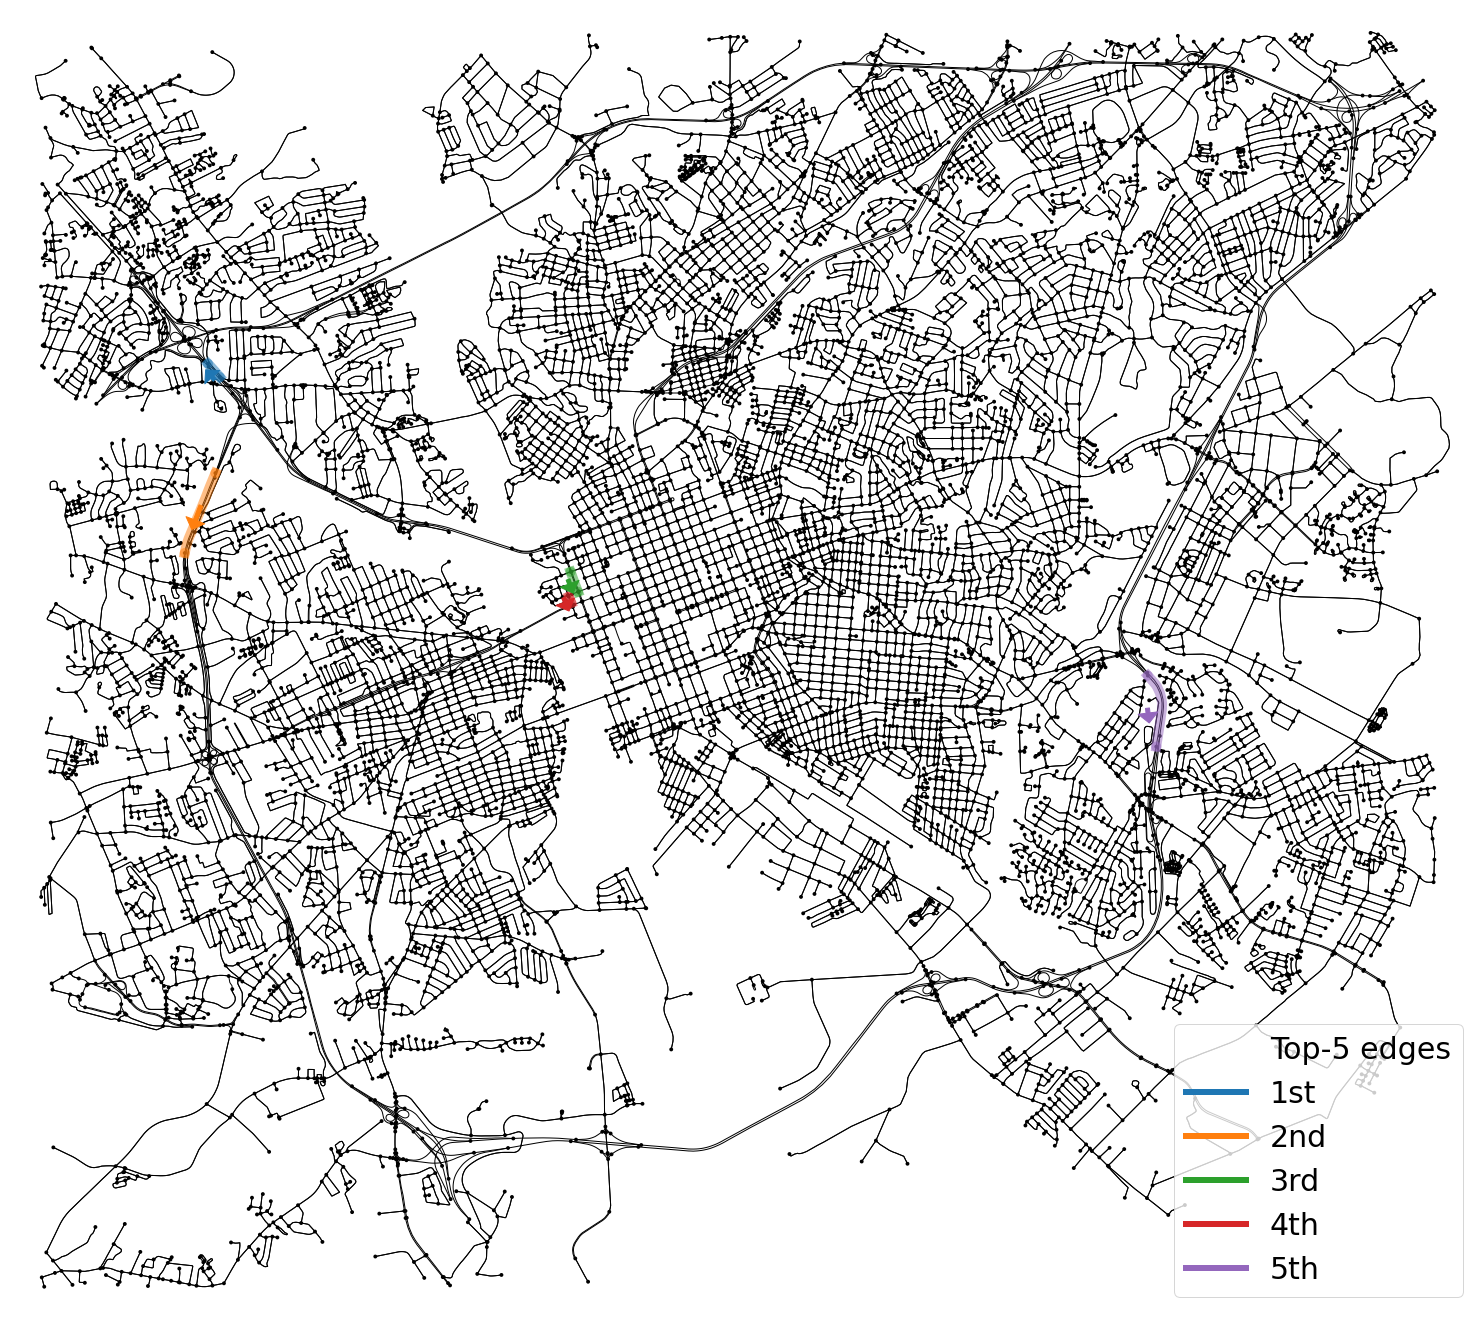

In [6]:
routes = []
for u,v,k in top5_bc:
    rt = [u,v]
    routes.append(rt)

print('Top-5 bet. cent. edges:')
for i, edge in enumerate(top5_bc):
    print('No.',i+1,':' , edge)
    
default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = ox.plot.plot_graph_routes(G, routes, figsize=(40,24), route_colors=default_colors[:5], 
                                    edge_color='k', node_color='k', bgcolor='w',
                                    route_linewidths=10, show=False, close=False, route_alpha=0.5)

for i, e in enumerate(routes):
    start_node = e[0]
    end_node = e[1]
    start_coord = (G.nodes[start_node]['x'] - 0.0006, G.nodes[start_node]['y'] - 0.0006)
    end_coord =  (G.nodes[end_node]['x'] - 0.0006, G.nodes[end_node]['y'] - 0.0006)

    # Annotate node ID if needed
    #atk_ax.annotate(start_node, xy=start_coord, color='white', weight='bold')
    #atk_ax.annotate(end_node, xy=end_coord, color='blue', weight='bold')

    middle_coord = (start_coord[0] + 0.5*(end_coord[0] - start_coord[0]), 
                    start_coord[1] + 0.5*(end_coord[1] - start_coord[1]))

    arrow_len = 0.001

    x_s = start_coord[0]
    y_s = start_coord[1]
    x_e = end_coord[0]
    y_e = end_coord[1]
    x_m = middle_coord[0]
    y_m = middle_coord[1]

    x_diff = x_s - x_m
    y_diff = y_s - y_m
    grad = y_diff / x_diff

    x_sign = x_diff / abs(x_diff)
    y_sign = y_diff / abs(y_diff)

    arrow_start_coord = (middle_coord[0] + 0.3*(start_coord[0] - middle_coord[0]), middle_coord[1] + 0.3*(start_coord[1] - middle_coord[1]))
    arrow_end_coord = (middle_coord[0] + 0.3*(end_coord[0] - middle_coord[0]), middle_coord[1] + 0.3*(end_coord[1] - middle_coord[1]))    
    dist = (((arrow_start_coord[0]-arrow_end_coord[0])**2 + (arrow_start_coord[1] - arrow_end_coord[1])**2)**0.5)

    if dist < 0.003:
            x_mov = x_sign*((arrow_len**2 / (1 + grad**2))**0.5)
            y_mov = y_sign*((arrow_len**2 - x_mov**2) ** 0.5)
            arrow_start_coord = (middle_coord[0] + x_mov, middle_coord[1] + y_mov)
            arrow_end_coord = (middle_coord[0] - x_mov, middle_coord[1] - y_mov)

    ax.annotate('', xy= arrow_end_coord, color='blue', weight='bold', 
                xytext= arrow_start_coord, textcoords='data', 
                arrowprops=dict(color=default_colors[i], headwidth=20, headlength=10, lw=1))

# Add legend
line_label, = plt.plot([0, 0, 0], label='1st', c='none', linewidth = 0)
line_1st, = plt.plot([0, 0, 0], label='1st', c=default_colors[0], linewidth = 6)
line_2nd, = plt.plot([0, 0, 0], label='2nd', c=default_colors[1], linewidth = 6)
line_3rd, = plt.plot([0, 0, 0], label='3rd', c=default_colors[2], linewidth = 6)
line_4th, = plt.plot([0, 0, 0], label='4th', c=default_colors[3], linewidth = 6)
line_5th, = plt.plot([0, 0, 0], label='5th', c=default_colors[4], linewidth = 6)


plt.legend([line_label, line_1st, line_2nd, line_3rd, line_4th, line_5th], 
           ['Top-5 edges', '1st', '2nd', '3rd', '4th', '5th'], prop={'size': 30})

plt.show()
plt.close('all')